In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

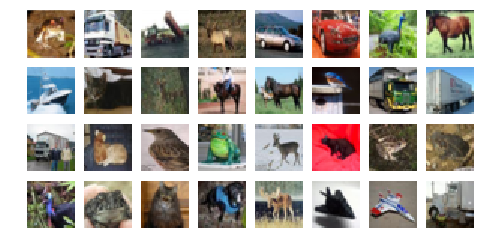

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

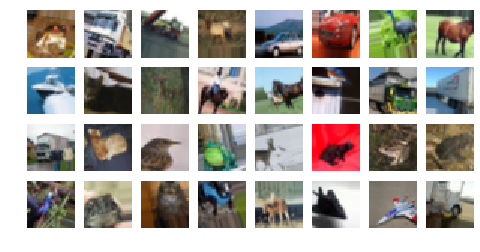

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。
#            (shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) 
# 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

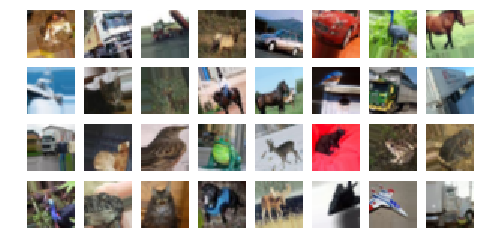

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

### 以下測試結果

data_generator with rotation_range=10, width_shift_range=0.1, height_shift_range=0.1
> loss: 0.8996 - acc: 0.6878 - val_loss: 0.7894 - val_acc: 0.7333

data_generator with rotation_range=10, width_shift_range=0.1, height_shift_range=0.2
> loss: 0.9695 - acc: 0.6611 - val_loss: 0.8978 - val_acc: 0.6977

data_generator with rotation_range=10, width_shift_range=0.2, height_shift_range=0.1
> loss: 0.9794 - acc: 0.6619 - val_loss: 0.8689 - val_acc: 0.7044

data_generator with rotation_range=10, width_shift_range=0.2, height_shift_range=0.2
> loss: 1.0623 - acc: 0.6265 - val_loss: 0.8548 - val_acc: 0.7012

data_generator with rotation_range=20, width_shift_range=0.1, height_shift_range=0.1
> loss: 0.9591 - acc: 0.6654 - val_loss: 0.8578 - val_acc: 0.7006

data_generator with rotation_range=20, width_shift_range=0.1, height_shift_range=0.2
> loss: 1.0412 - acc: 0.6368 - val_loss: 0.8745 - val_acc: 0.6953

data_generator with rotation_range=20, width_shift_range=0.2, height_shift_range=0.1
> loss: 1.0282 - acc: 0.6406 - val_loss: 0.9242 - val_acc: 0.6949

data_generator with rotation_range=20, width_shift_range=0.2, height_shift_range=0.2
> loss: 1.1054 - acc: 0.6119 - val_loss: 0.9131 - val_acc: 0.6831

不使用 資料增強 Data augmentation
> loss: 0.6522 - acc: 0.7743 - val_loss: 0.7126 - val_acc: 0.7584

In [8]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

import os
import itertools

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICE"] = "0"

In [9]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

In [10]:
# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [11]:
# 觀察不同的圖像增強方法是否會顯著影響訓練結果
ROTATION_RANGE = [10, 20]
WIDTH_SHIFT_RANGE = [0.1, 0.2]
HEIGHT_SHIFT_RANGE = [0.1, 0.2]

### 觀察不同的圖像增強方法是否會顯著影響訓練結果

In [12]:
for rotation_range, width_shift_range, height_shift_range in itertools.product(
    ROTATION_RANGE, WIDTH_SHIFT_RANGE, HEIGHT_SHIFT_RANGE):
    
    print(f"data_generator with rotation_range={rotation_range}, width_shift_range={width_shift_range}, height_shift_range={height_shift_range}")
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    # 並觀察不同的圖像增強方法是否會顯著影響訓練結果
    data_generator = ImageDataGenerator(
        rotation_range=rotation_range, 
        width_shift_range=width_shift_range, 
        height_shift_range=height_shift_range, 
        horizontal_flip=True)

    history = model.fit_generator(
        # ImageDataGenerator
        data_generator.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

W0805 23:10:20.566935 10392 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0805 23:10:20.567944 10392 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0805 23:10:20.585928 10392 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 23:10:20.587926 10392 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 23:10:20.590925 10392 depr

data_generator with rotation_range=10, width_shift_range=0.1, height_shift_range=0.1


W0805 23:10:20.919833 10392 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 23:10:21.035796 10392 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

390/390 [==============================] - 19s 50ms/step - loss: 0.9695 - acc: 0.6611 - val_loss: 0.8978 - val_acc: 0.6977
Test loss: 0.897805364227295
Test accuracy: 0.6977
data_generator with rotation_range=10, width_shift_range=0.2, height_shift_range=0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_______________

390/390 [==============================] - 19s 50ms/step - loss: 1.1154 - acc: 0.6057 - val_loss: 0.9097 - val_acc: 0.6789
Epoch 9/10
390/390 [==============================] - 20s 50ms/step - loss: 1.0907 - acc: 0.6156 - val_loss: 0.9767 - val_acc: 0.6585
Epoch 10/10
390/390 [==============================] - 19s 50ms/step - loss: 1.0623 - acc: 0.6265 - val_loss: 0.8548 - val_acc: 0.7012
Test loss: 0.854823113155365
Test accuracy: 0.7012
data_generator with rotation_range=20, width_shift_range=0.1, height_shift_range=0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
__________

390/390 [==============================] - 19s 50ms/step - loss: 1.1678 - acc: 0.5864 - val_loss: 0.9927 - val_acc: 0.6484
Epoch 7/10
390/390 [==============================] - 19s 50ms/step - loss: 1.1251 - acc: 0.6031 - val_loss: 0.9248 - val_acc: 0.6869
Epoch 8/10
390/390 [==============================] - 19s 50ms/step - loss: 1.0850 - acc: 0.6202 - val_loss: 0.9045 - val_acc: 0.6833
Epoch 9/10
390/390 [==============================] - 20s 51ms/step - loss: 1.0653 - acc: 0.6295 - val_loss: 0.7900 - val_acc: 0.7275
Epoch 10/10
390/390 [==============================] - 21s 53ms/step - loss: 1.0412 - acc: 0.6368 - val_loss: 0.8745 - val_acc: 0.6953
Test loss: 0.8744742023468017
Test accuracy: 0.6953
data_generator with rotation_range=20, width_shift_range=0.2, height_shift_range=0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_____

390/390 [==============================] - 20s 51ms/step - loss: 1.3393 - acc: 0.5196 - val_loss: 1.1061 - val_acc: 0.6067
Epoch 5/10
390/390 [==============================] - 20s 52ms/step - loss: 1.2708 - acc: 0.5468 - val_loss: 1.1238 - val_acc: 0.6071
Epoch 6/10
390/390 [==============================] - 20s 52ms/step - loss: 1.2204 - acc: 0.5657 - val_loss: 1.0308 - val_acc: 0.6357
Epoch 7/10
390/390 [==============================] - 20s 52ms/step - loss: 1.1868 - acc: 0.5795 - val_loss: 1.0226 - val_acc: 0.6445
Epoch 8/10
390/390 [==============================] - 20s 52ms/step - loss: 1.1514 - acc: 0.5934 - val_loss: 0.9710 - val_acc: 0.6589
Epoch 9/10
390/390 [==============================] - 20s 52ms/step - loss: 1.1276 - acc: 0.6049 - val_loss: 1.1342 - val_acc: 0.6058
Epoch 10/10
390/390 [==============================] - 20s 52ms/step - loss: 1.1054 - acc: 0.6119 - val_loss: 0.9131 - val_acc: 0.6831
Test loss: 0.9130959342956543
Test accuracy: 0.6831


### 不使用 資料增強 Data augmentation

In [14]:
keras.backend.clear_session() # 把舊的 Graph 清掉
    
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________